In [3]:
################################################################################
# 0. Configurações e importações
################################################################################
%matplotlib inline  

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score, LeaveOneOut
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, LogisticRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample



In [4]:
################################################################################
# 1. Carregar dados
################################################################################
DATA_PATH = "Desktop/Mestrado/1_Semestre/APRAU/trabalho/group_21.csv" 

print("Carregando dados de:", DATA_PATH)
df = pd.read_csv(DATA_PATH, sep=None, engine='python')
print("Dimensão:", df.shape)
print(df.columns.tolist())


Carregando dados de: Desktop/Mestrado/1_Semestre/APRAU/trabalho/group_21.csv
Dimensão: (2999, 49)
['duration_1', 'duration_2', 'duration_3', 'duration_4', 'duration_5', 'loudness_level', 'popularity_level', 'tempo_class', 'time_signature', 'key_mode', 'artist_song_count', 'album_freq', 'movement_index', 'intensity_level', 'verbal_density', 'purity_score', 'positivity_index', 'activity_rate', 'loudness_intensity', 'happy_dance', 'acoustics_instrumental', 'artists_avg_popularity', 'tempo_vs_genre', 'energy_rank_pct', 'loud_energy_ratio', 'mood_pca', 'mood_cluster', 'acoustic_valence_mood_cluster', 'explicit', 'signal_strength', 'mode_indicator', 'focus_factor', 'ambient_level', 'key_sin', 'key_cos', 'duration_log', 'duration_log_z', 'time_signature_class_boolean', 'loudness_yeo', 'is_instrumental', 'is_dance_hit', 'temp_zscore', 'resonance_factor', 'timbre_index', 'echo_constant', 'distorted_movement', 'signal_power', 'target_class', 'target_regression']


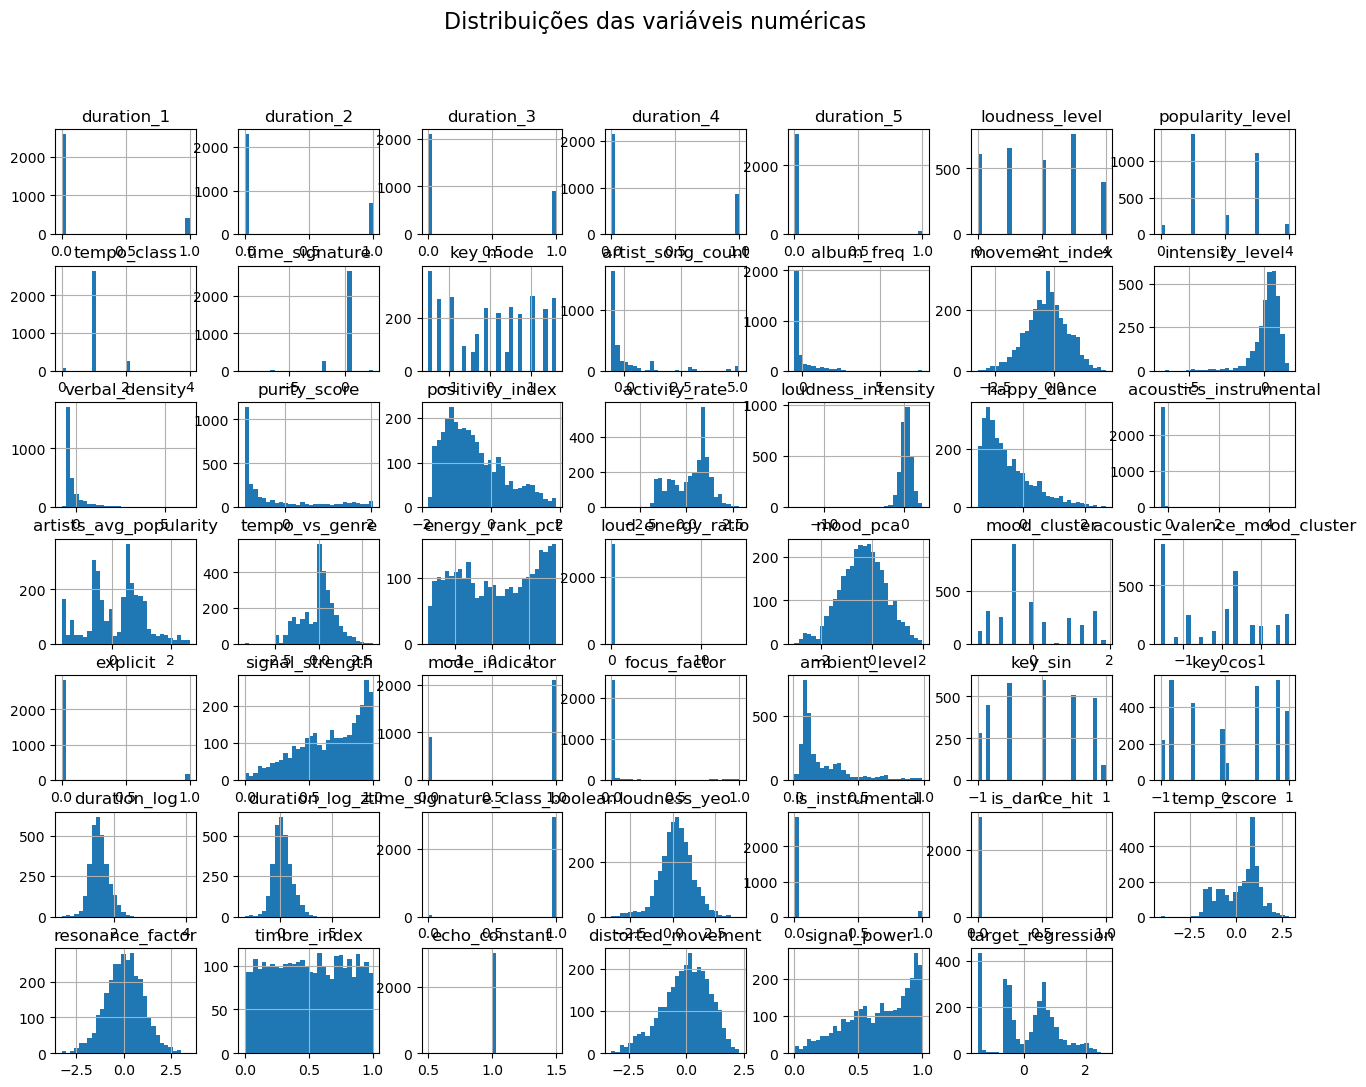

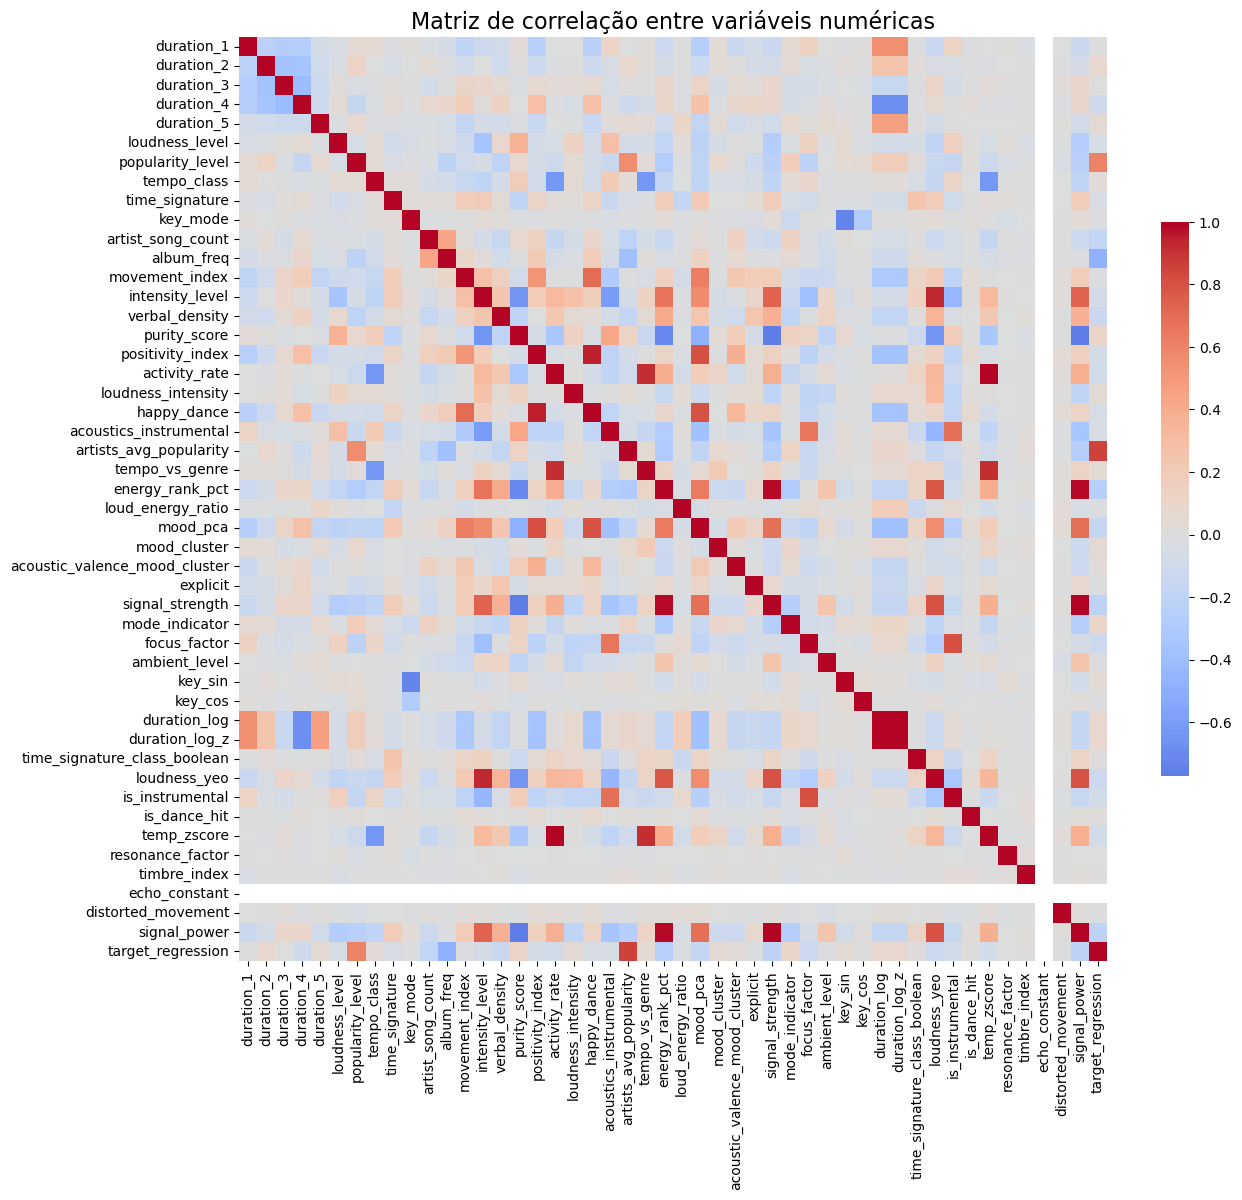

In [9]:
################################################################################
# 2. EDA rápida: estatísticas descritivas, univariada e bivariada
################################################################################
# Substituir vírgulas por pontos e converter para float
for col in df.columns:
    if df[col].dtype == 'object':
        try:
            df[col] = df[col].str.replace(',', '.').astype(float)
        except:
            pass

# Selecionar colunas numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Histogramas
df[numeric_cols].hist(bins=30, figsize=(16,12))
plt.suptitle("Distribuições das variáveis numéricas", fontsize=16)
plt.show()

# Matriz de correlação
corr = df[numeric_cols].corr()
plt.figure(figsize=(14,12))
sns.heatmap(corr, cmap='coolwarm', center=0, fmt='.2f', cbar_kws={'shrink': .6})
plt.title("Matriz de correlação entre variáveis numéricas", fontsize=16)
plt.show()


In [28]:
# 2.1 Estatísticas básicas
desc_stats = df[numeric_cols].describe().T
desc_stats['missing'] = df[numeric_cols].isna().sum()
display(desc_stats)


,count,mean,std,min,25%,50%,75%,max,missing
duration_1,2999.0,0.142381,0.349499,0.000000,0.000000,0.000000e+00,0.000000,1.000000,0
duration_2,2999.0,0.236412,0.424949,0.000000,0.000000,0.000000e+00,0.000000,1.000000,0
duration_3,2999.0,0.303101,0.459675,0.000000,0.000000,0.000000e+00,1.000000,1.000000,0
duration_4,2999.0,0.286429,0.452168,0.000000,0.000000,0.000000e+00,1.000000,1.000000,0
duration_5,2999.0,0.031677,0.175169,0.000000,0.000000,0.000000e+00,0.000000,1.000000,0
loudness_level,2999.0,1.892964,1.346634,0.000000,1.000000,2.000000e+00,3.000000,4.000000,0
popularity_level,2999.0,1.918973,1.083152,0.000000,1.000000,2.000000e+00,3.000000,4.000000,0
tempo_class,2999.0,1.067689,0.335402,0.000000,1.000000,1.000000e+00,1.000000,4.000000,0
time_signature,2999.0,-0.017110,0.942046,-9.024149,0.221824,2.218242e-01,0.221824,2.533318,0
key_mode,2999.0,0.027457,1.025497,-1.511882,-0.920961,1.764658e-01,1.020640,1.611562,0


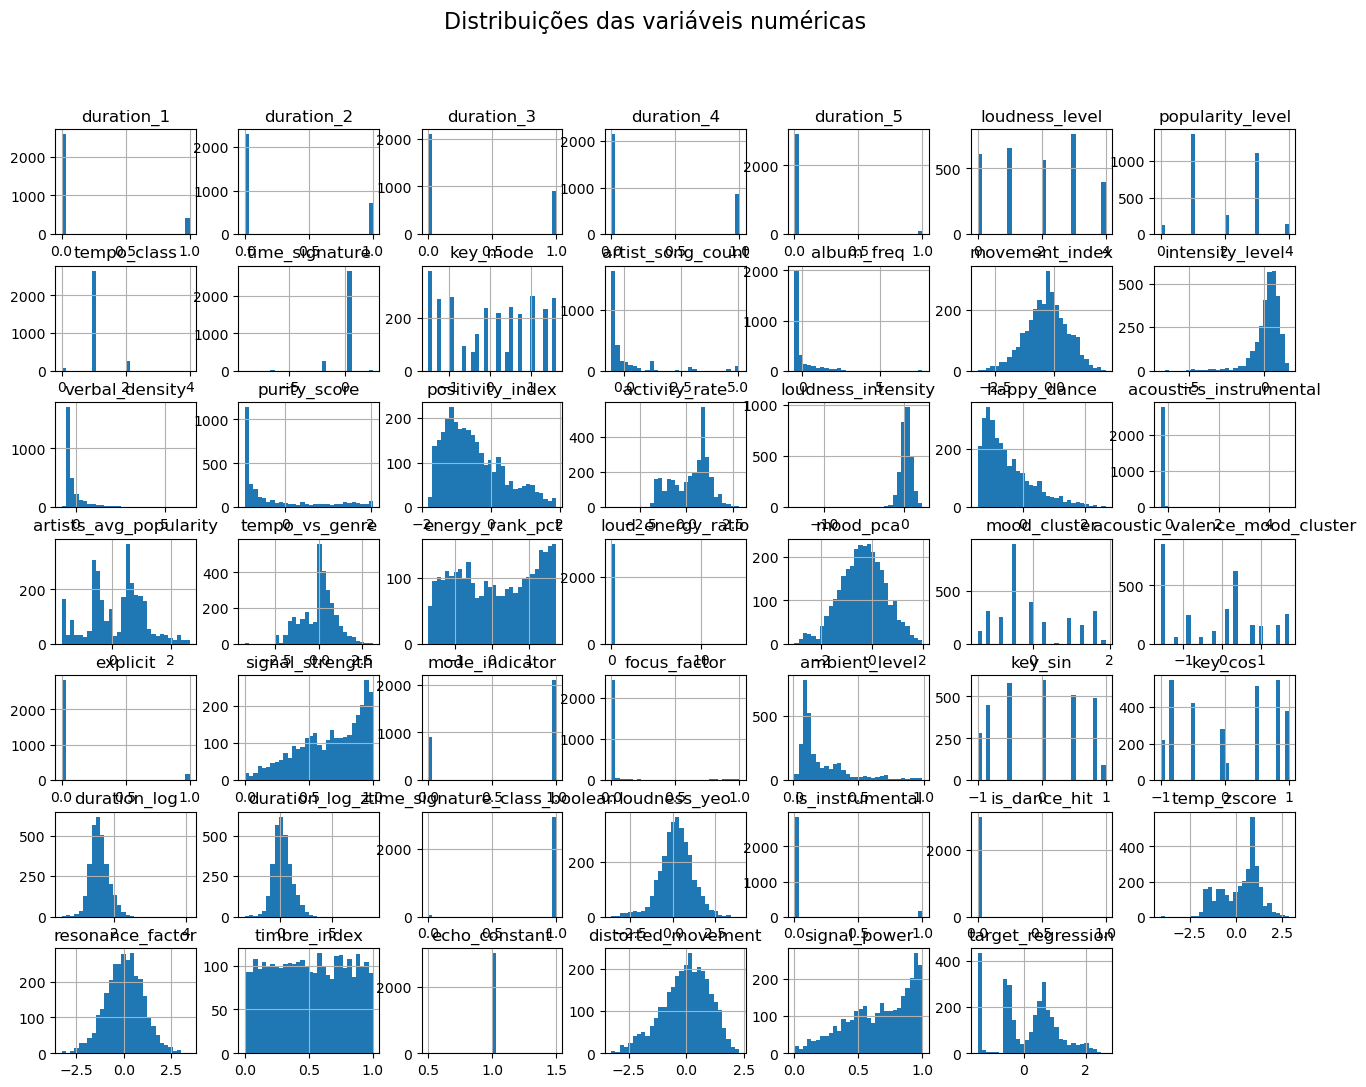

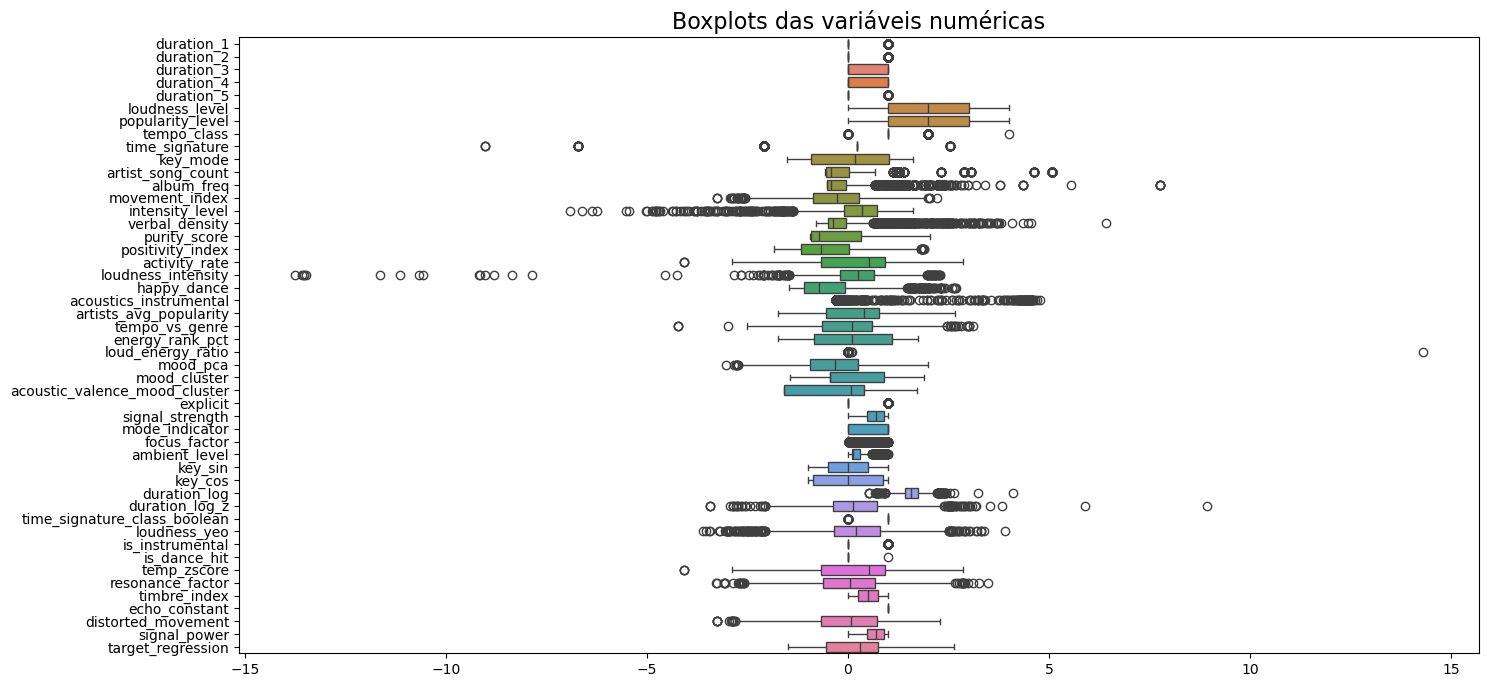

In [29]:
# 2.2 Histogramas
df[numeric_cols].hist(bins=30, figsize=(16,12))
plt.suptitle("Distribuições das variáveis numéricas", fontsize=16)
plt.show()

# Boxplots (opcional, para outliers)
plt.figure(figsize=(16,8))
sns.boxplot(data=df[numeric_cols], orient='h')
plt.title("Boxplots das variáveis numéricas", fontsize=16)
plt.show()

In [36]:
################################################################################
# 2b. Bivariate Analysis - Relação das features numéricas com TARGET_REG
################################################################################

# Número de features mais correlacionadas a mostrar
top_n = 6

# Calcular correlação com o target
target_col = str(TARGET_REG)
corr_matrix = df[numeric_cols + [target_col]].corr()
corr_target_reg = corr_matrix[target_col].drop(target_col)  # remover correlação do target consigo mesmo
corr_target_reg_sorted = corr_target_reg.abs().sort_values(ascending=False)  # ordenar pelo valor absoluto

# Selecionar top N features
top_features = corr_target_reg_sorted.head(top_n).index.tolist()
print(f"Top {top_n} features mais correlacionadas com {TARGET_REG}:")
print(corr_target_reg_sorted.head(top_n))

# Gráficos de dispersão
plt.figure(figsize=(16, 4*top_n))
for i, feat in enumerate(top_features):
    plt.subplot(top_n, 1, i+1)
    sns.scatterplot(x=df[feat], y=df[target_col], alpha=0.6)
    plt.xlabel(feat)
    plt.ylabel(target_col)
    plt.title(f"{feat} vs {target_col} | Corr = {corr_matrix.loc[feat, target_col]:.3f}")
plt.tight_layout()
plt.show()


TypeError: DataFrame.sort_values() missing 1 required positional argument: 'by'

In [10]:
################################################################################
# 3. Preparação de features e variáveis alvo
################################################################################
TARGET_REG = 'target_regression'
TARGET_CLASS = 'target_class'

# Codificar target_class se for categórico
if df[TARGET_CLASS].dtype == 'object' or df[TARGET_CLASS].dtype.name == 'category':
    y_class = df[TARGET_CLASS].astype('category')
    class_labels = y_class.cat.categories.tolist()
    y_class_codes = y_class.cat.codes
else:
    y_class_codes = df[TARGET_CLASS]

# Selecionar features, removendo targets
exclude = [TARGET_REG, TARGET_CLASS]
features = [c for c in df.columns if c not in exclude]

# Selecionar apenas colunas numéricas
num_features = []
for c in features:
    # Tentar converter strings numéricas com vírgula
    if df[c].dtype == 'object':
        try:
            df[c] = df[c].str.replace(',', '.').astype(float)
            num_features.append(c)
        except:
            pass  # ignora colunas não numéricas
    elif np.issubdtype(df[c].dtype, np.number):
        num_features.append(c)

print(f"Utilizando {len(num_features)} features numéricas para modelos.")
X = df[num_features].copy()

# Tratar valores faltantes: preencher com mediana
X = X.fillna(X.median())

Utilizando 47 features numéricas para modelos.


In [12]:
################################################################################
# Preparação dos dados para regressão
################################################################################

# Definir X e y para regressão
y = df[TARGET_REG].values
X_vals = X.values  # apenas as features numéricas já limpas

# Separar treino/teste
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_vals, y, test_size=0.2, random_state=42
)

# Normalizar features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

print(f"Shape treino: {X_train_s.shape}, Shape teste: {X_test_s.shape}")


Shape treino: (2399, 47), Shape teste: (600, 47)


,Feature,R2,RMSE,MAE
21,artists_avg_popularity,0.745367,0.481198,0.261306
6,popularity_level,0.409337,0.732886,0.501157
11,album_freq,0.208148,0.848572,0.702336
23,energy_rank_pct,0.056875,0.926086,0.725197
29,signal_strength,0.044373,0.932204,0.745114
46,signal_power,0.044373,0.932204,0.745114
10,artist_song_count,0.038494,0.935067,0.793418
25,mood_pca,0.030446,0.938973,0.769529
14,verbal_density,0.026404,0.940928,0.766457
30,mode_indicator,0.018779,0.944605,0.780993


Melhor feature (linear simples): artists_avg_popularity | R² = 0.745
Métricas do modelo simples com melhor feature:
{'r2': 0.7453673242898666, 'rmse': np.float64(0.4811981476475585), 'mae': 0.2613064303722567}


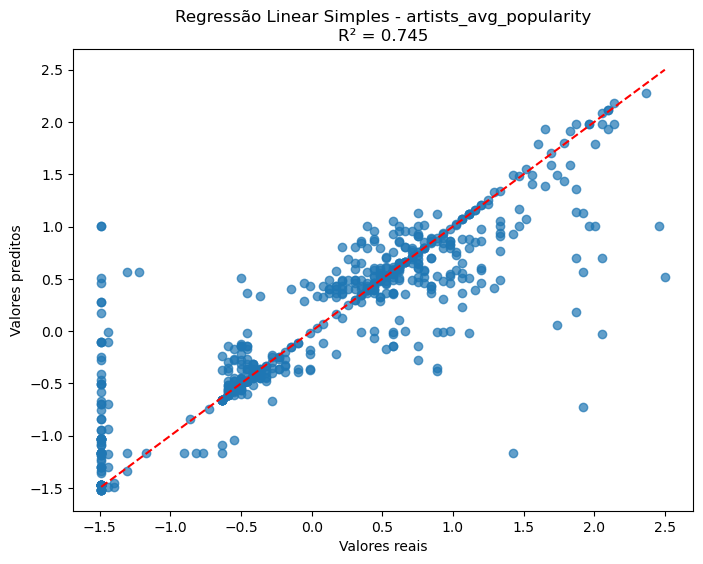

In [13]:
best_feat = None
best_r2 = -np.inf
simple_results = []

for i, feat in enumerate(num_features):
    lr = LinearRegression()
    lr.fit(X_train_s[:, i].reshape(-1, 1), y_train)
    y_pred = lr.predict(X_test_s[:, i].reshape(-1, 1))
    
    # Métricas
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)  # RMSE manual (compatível com qualquer versão sklearn)
    mae = mean_absolute_error(y_test, y_pred)
    
    simple_results.append((feat, r2, rmse, mae))
    
    # Atualizar melhor feature
    if r2 > best_r2:
        best_r2 = r2
        best_feat = feat

# Mostrar ranking das features
results_df = pd.DataFrame(simple_results, columns=['Feature', 'R2', 'RMSE', 'MAE']).sort_values('R2', ascending=False)
display(results_df)

print(f"Melhor feature (linear simples): {best_feat} | R² = {best_r2:.3f}")

# Ajustar modelo final simples com a melhor feature
lr_best = LinearRegression()
ix = num_features.index(best_feat)
lr_best.fit(X_train_s[:, ix].reshape(-1, 1), y_train)
y_pred_best = lr_best.predict(X_test_s[:, ix].reshape(-1, 1))

# Métricas do modelo final
mse_best = mean_squared_error(y_test, y_pred_best)
metrics_simple = {
    'r2': r2_score(y_test, y_pred_best),
    'rmse': np.sqrt(mse_best),
    'mae': mean_absolute_error(y_test, y_pred_best)
}

print("Métricas do modelo simples com melhor feature:")
print(metrics_simple)

# Gráfico de dispersão: valores reais vs preditos
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_best, alpha=0.7)
plt.xlabel("Valores reais")
plt.ylabel("Valores preditos")
plt.title(f"Regressão Linear Simples - {best_feat}\nR² = {metrics_simple['r2']:.3f}")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # linha identidade
plt.show()

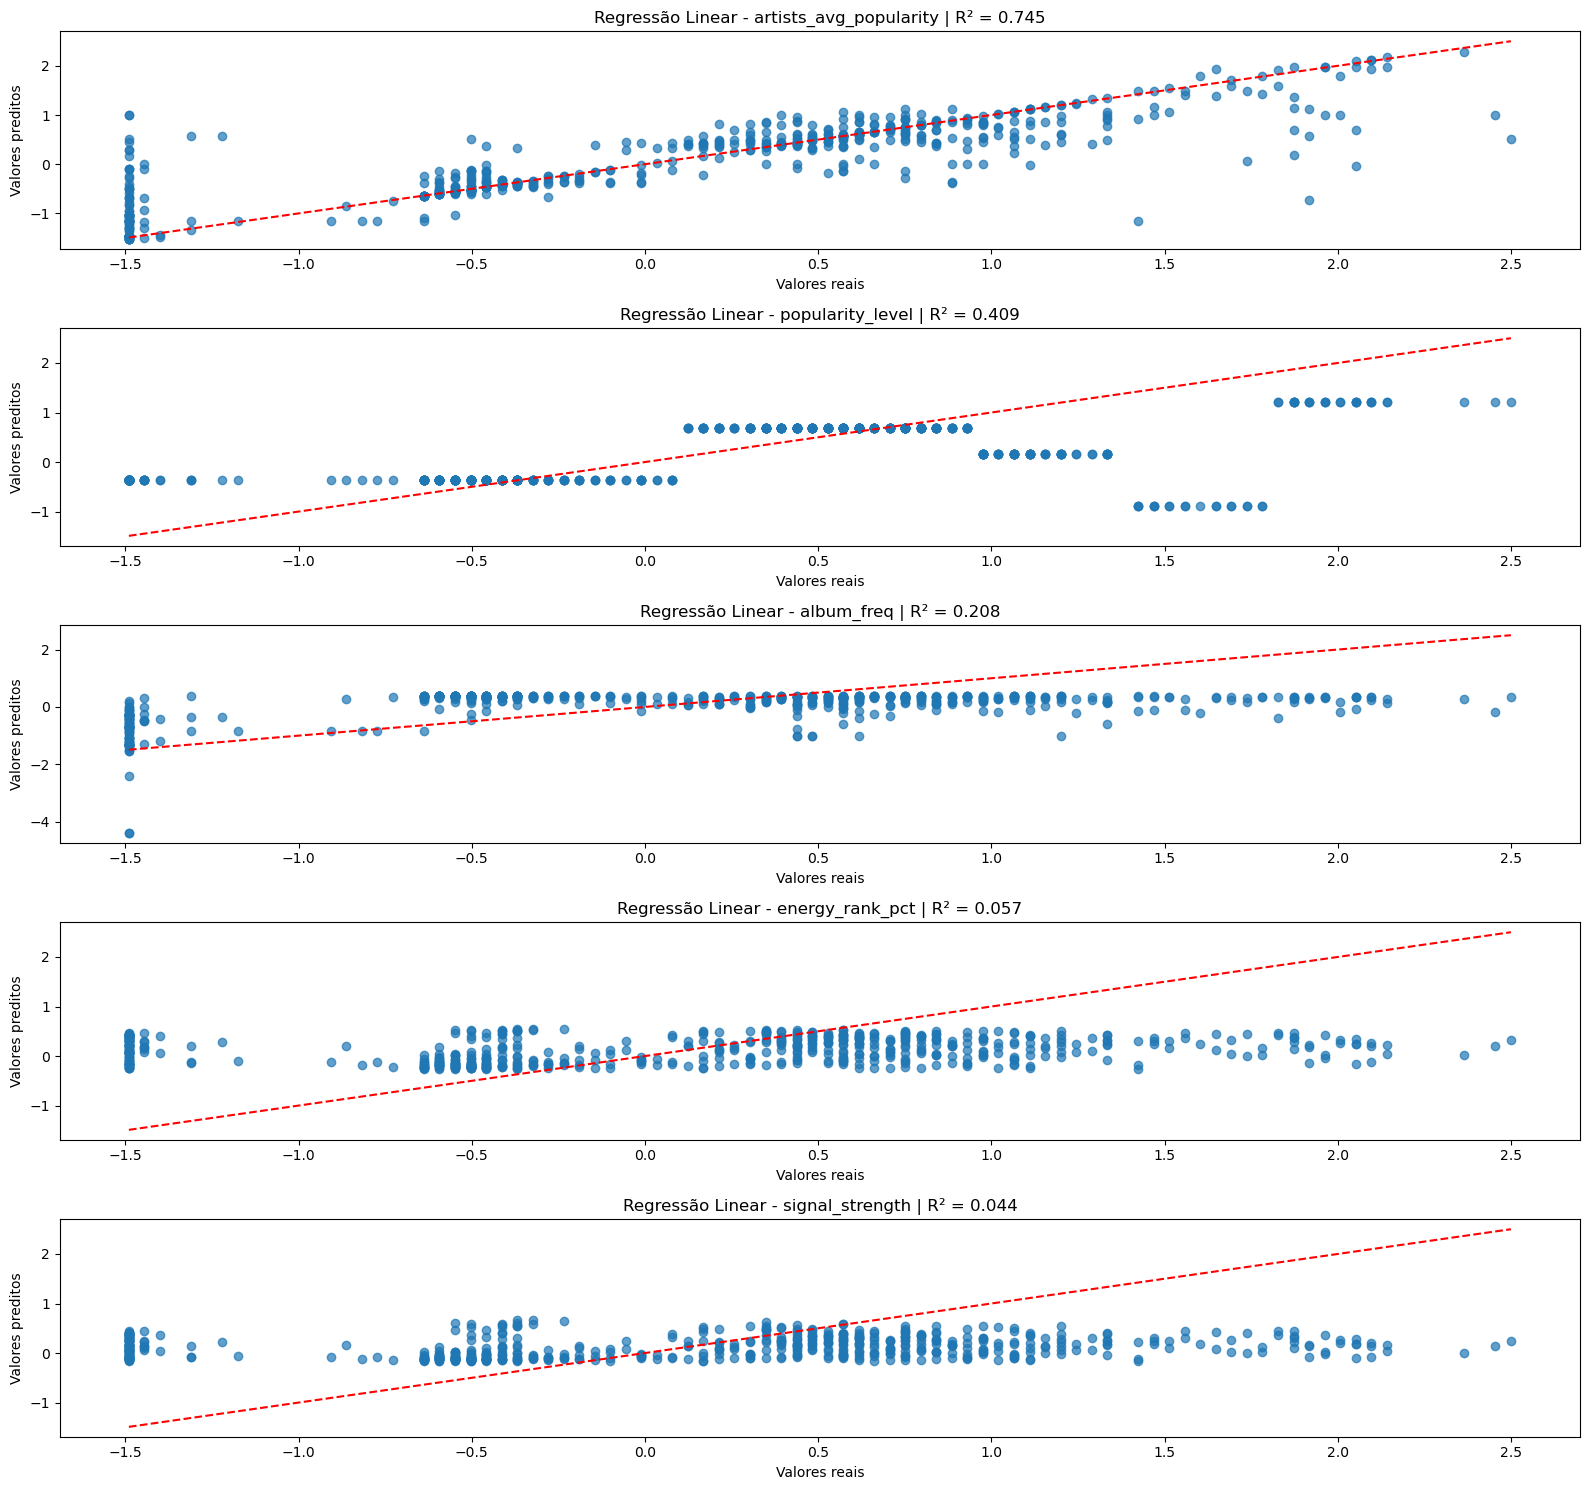

In [27]:
# Escolher top N features
top_n = 5
top_features = results_df.head(top_n)['Feature'].tolist()

plt.figure(figsize=(16, 3*top_n))  # altura proporcional ao número de gráficos

for i, feat in enumerate(top_features):
    ix = num_features.index(feat)
    lr = LinearRegression()
    lr.fit(X_train_s[:, ix].reshape(-1, 1), y_train)
    y_pred = lr.predict(X_test_s[:, ix].reshape(-1, 1))
    
    plt.subplot(top_n, 1, i+1)
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Valores reais")
    plt.ylabel("Valores preditos")
    r2 = r2_score(y_test, y_pred)
    plt.title(f"Regressão Linear - {feat} | R² = {r2:.3f}")

plt.tight_layout()
plt.show()


Métricas do modelo de múltiplas features:
{'r2': 0.7967117328931801, 'rmse': np.float64(0.4299550328287892), 'mae': 0.2755771112661796}

Comparação dos modelos:


,Modelo,R2,RMSE,MAE
0,Linear Simples,0.745367,0.481198,0.261306
1,Linear Múltipla,0.796712,0.429955,0.275577


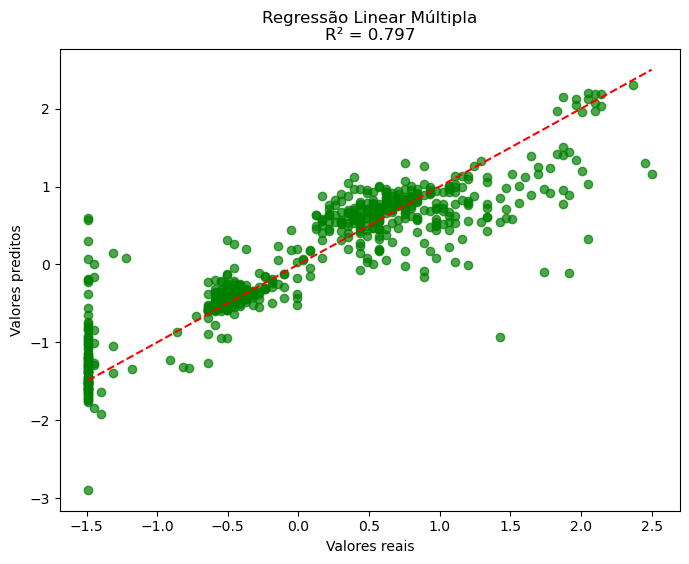

In [14]:
################################################################################
# Multiple Linear Regression - todas as features numéricas
################################################################################

from itertools import combinations

# Inicializar modelo
lr_multi = LinearRegression()

# Treinar com todas as features
lr_multi.fit(X_train_s, y_train)
y_pred_multi = lr_multi.predict(X_test_s)

# Métricas
mse_multi = mean_squared_error(y_test, y_pred_multi)
metrics_multi = {
    'r2': r2_score(y_test, y_pred_multi),
    'rmse': np.sqrt(mse_multi),
    'mae': mean_absolute_error(y_test, y_pred_multi)
}

print("Métricas do modelo de múltiplas features:")
print(metrics_multi)

# Comparação com a regressão simples
print("\nComparação dos modelos:")
comparison_df = pd.DataFrame({
    'Modelo': ['Linear Simples', 'Linear Múltipla'],
    'R2': [metrics_simple['r2'], metrics_multi['r2']],
    'RMSE': [metrics_simple['rmse'], metrics_multi['rmse']],
    'MAE': [metrics_simple['mae'], metrics_multi['mae']]
})
display(comparison_df)

# Gráfico: valores reais vs preditos para múltipla
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_multi, alpha=0.7, color='green')
plt.xlabel("Valores reais")
plt.ylabel("Valores preditos")
plt.title(f"Regressão Linear Múltipla\nR² = {metrics_multi['r2']:.3f}")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

################################################################################
# Discussão curta:
################################################################################
# - Comparar R²: a regressão múltipla normalmente terá R² maior, pois usa mais informações.
# - RMSE e MAE: valores menores indicam melhor ajuste.
# - Se a diferença for pequena, talvez a feature simples seja suficiente.


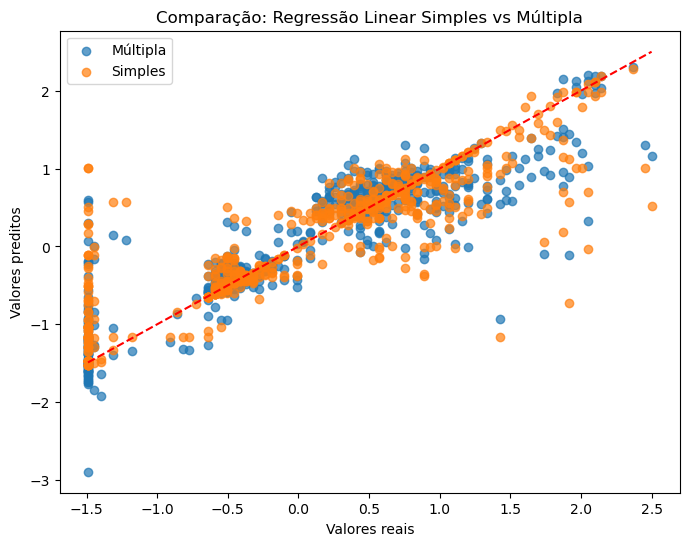

In [16]:
################################################################################
# 6. Comparação Simples vs Múltipla
################################################################################
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_multi, alpha=0.7, label='Múltipla')
plt.scatter(y_test, lr_best.predict(X_test_s[:, num_features.index(best_feat)].reshape(-1, 1)), alpha=0.7, label='Simples')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Valores reais")
plt.ylabel("Valores preditos")
plt.title("Comparação: Regressão Linear Simples vs Múltipla")
plt.legend()
plt.show()

In [24]:
################################################################################
# 6. Separar treino/teste para classificação
################################################################################
# Selecionar features numéricas
num_features = [c for c in df.columns if c not in [TARGET_REG, TARGET_CLASS] and np.issubdtype(df[c].dtype, np.number)]
X = df[num_features].fillna(df[num_features].median())

# Normalizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Targets
y_class = y_class_codes.values
y_reg = df[TARGET_REG].values

# Agora sim, separar treino/teste para classificação
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_scaled, y_class, test_size=0.2, random_state=42, stratify=y_class
)

C:\Users\rui.couto\AppData\Local\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
C:\Users\rui.couto\AppData\Local\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
C:\Users\rui.couto\AppData\Local\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
C:\Users\rui.couto\AppData\Local\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter

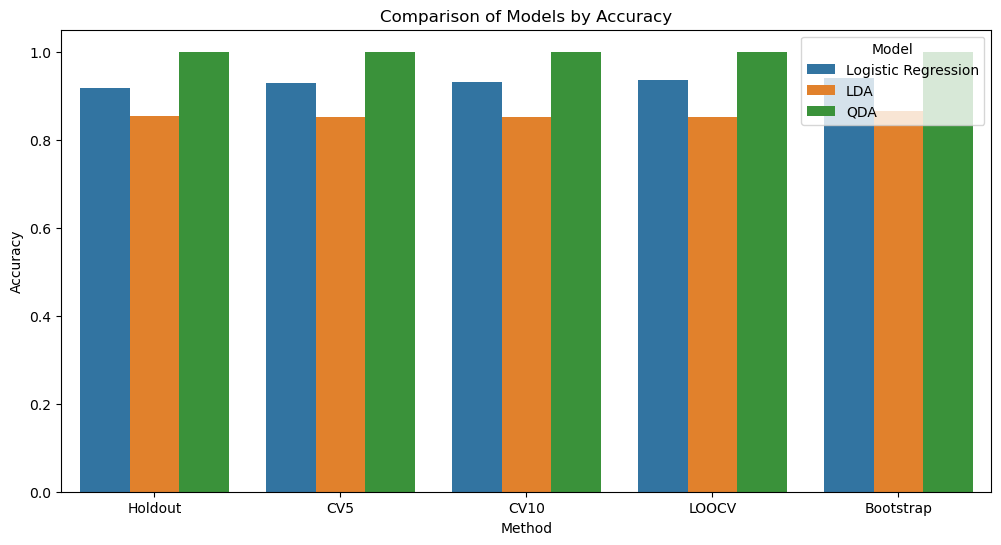

In [26]:
################################################################################
# 7. Classificação: modelos e resampling
################################################################################
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "LDA": LDA(),
    "QDA": QDA()
}

# Inicializar dicionário de resultados
results = {'Holdout': {}, 'CV5': {}, 'CV10': {}, 'LOOCV': {}, 'Bootstrap': {}}

# --- Holdout ---
for name, model in models.items():
    model.fit(X_train_c, y_train_c)
    y_pred = model.predict(X_test_c)
    acc = accuracy_score(y_test_c, y_pred)
    f1 = f1_score(y_test_c, y_pred, average='weighted')
    results['Holdout'][name] = {'Accuracy': acc, 'F1': f1}

# --- K-Fold Cross Validation (CV5 e CV10) ---
for k in [5, 10]:
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    key = f'CV{k}'
    for name, model in models.items():
        scores = cross_val_score(model, X_scaled, y_class, cv=skf, scoring='accuracy')
        results[key][name] = {'Accuracy': scores.mean(), 'F1': np.nan}

# --- LOOCV ---
loo = LeaveOneOut()
for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y_class, cv=loo, scoring='accuracy', n_jobs=-1)
    results['LOOCV'][name] = {'Accuracy': scores.mean(), 'F1': np.nan}

# --- Bootstrap ---
n_bootstrap = 100
for name, model in models.items():
    acc_list = []
    for _ in range(n_bootstrap):
        idx = resample(np.arange(X_scaled.shape[0]), replace=True)
        X_bs, y_bs = X_scaled[idx], y_class[idx]
        model.fit(X_bs, y_bs)
        y_pred = model.predict(X_bs)
        acc_list.append(accuracy_score(y_bs, y_pred))
    results['Bootstrap'][name] = {'Accuracy': np.mean(acc_list), 'F1': np.nan}

# --- Transformar resultados em DataFrame para plot ---
df_plot = []
for method, res_dict in results.items():
    for model_name, metrics in res_dict.items():
        df_plot.append({'Method': method, 'Model': model_name, 'Accuracy': metrics['Accuracy'], 'F1': metrics['F1']})
df_plot = pd.DataFrame(df_plot)

# --- Plot Accuracy ---
plt.figure(figsize=(12,6))
sns.barplot(x='Method', y='Accuracy', hue='Model', data=df_plot)
plt.title('Comparison of Models by Accuracy')
plt.ylim(0, 1.05)
plt.legend(title='Model')
plt.show()

In [7]:
################################################################################
# 8. Seleção de Features para classificação
################################################################################

# Usando Lasso (Regressão logística com penalização L1)
clf_lasso = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
clf_lasso.fit(X_train_s, y_class_final)

selected_features_class = [f for f, coef in zip(num_features, clf_lasso.coef_[0]) if abs(coef) > 1e-5]
print(f"Features selecionadas pelo Lasso (classificação): {selected_features_class}")

# Reajustar modelo apenas com features selecionadas
ix_selected_class = [num_features.index(f) for f in selected_features_class]
clf_final = LogisticRegression(max_iter=1000)
clf_final.fit(X_train_s[:, ix_selected_class], y_class_final)
y_pred_final = clf_final.predict(X_test_s[:, ix_selected_class])
acc_final = (y_pred_final == y_class_final.iloc[:len(y_pred_final)]).mean()
print(f"Accuracy com features selecionadas: {acc_final:.3f}")


NameError: name 'X_train_s' is not defined